# NNsight 0.5: Official Walkthrough

**We have many exciting new features in this update!**

`NNsight 0.5` represents a complete redesign from the ground up focused on addressing user concerns related to debugging and performing fine-grained interventions. Now, we have direct execution of user code and no longer need to work with the complexity of proxies.

The following walkthrough guides you through how to access `NNsight 0.5` and use all of its individual features. As this update changes how `NNsight` works, we will structure this walkthrough in three sections:
1.   Core behavior
2.   Breaking changes
3.   New features

Thought and opinions and the direction of NNsight are invaluable to our organization: Please report any bugs or feedback on our forum: https://discuss.ndif.us

**Now, let's get started by installing `NNsight 0.5` and initializing the GPT-2 model.**

In [1]:
from IPython.display import clear_output
!pip install -U nnsight
clear_output()

In [2]:
import nnsight

nnsight.__version__

/opt/anaconda3/envs/nnsight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.5.0'

In [3]:
# save packages using pip freeze
!pip freeze
clear_output()

In [4]:
# import nnsight packages
import nnsight
import torch
from nnsight import LanguageModel

In [5]:
model = LanguageModel('openai-community/gpt2', device_map='auto')
print(model)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): Generator(
    (streamer): Streamer()
  )
)


# Core Behavior

Now that we have `NNsight 0.5` installed and GPT-2 instantiated, let's dig deeper into the core changes we've implemented with this update.

## No More Proxies!

`NNsight` previously used proxies to help trace and intervene on model internals. This meant anything that didn’t fit into the proxy graph had to be manually supported. With `NNsight 0.5`, there are no more proxies. Now, user code is executed directly inside the trace context, which enables use of breakpoints, print statements, libraries and custom functions, etc.

For example, we can now directly print model values within the tracing context without using NNsight's log function.

<maybe include a third party library here >
<before, if soemthing wasnt supported by nnsight to fit into the proxing intervention graph design, it had to be manually supported, now because use code is directly executed, you can do anythin >

In [6]:
with model.trace("Hello World"):
  # print statement within trace context
  print("Starting Intervention")

  l1 = model.transformer.h[0].output

  print('l1', l1)

  l2 = model.transformer.h[1].output

  l3 = model.transformer.h[2].output.save()

print(l3)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Starting Intervention
l1 (tensor([[[ 0.6784, -1.4596,  0.8340,  ..., -0.8639,  0.0798, -1.6176],
         [-1.6008,  0.3668,  0.7506,  ..., -1.1595, -0.5517,  0.3558]]],
       device='cuda:0', grad_fn=<AddBackward0>),)
(tensor([[[ 1.1259, -2.1527,  0.9124,  ..., -0.9309, -0.3252, -1.0321],
         [ 0.1096,  0.2835,  0.9886,  ..., -1.1560, -0.5406,  0.7856]]],
       device='cuda:0', grad_fn=<AddBackward0>),)


Let's try using a breakpoint to inspect an activation.

In [7]:
with model.trace("Hello World"):

  l1 = model.transformer.h[0].output

  breakpoint()

> <nnsight 138764089777696>(10)__nnsight_tracer_138764089715760__()

ipdb> l1
(tensor([[[ 0.6784, -1.4596,  0.8340,  ..., -0.8639,  0.0798, -1.6176],
         [-1.6008,  0.3668,  0.7506,  ..., -1.1595, -0.5517,  0.3558]]],
       device='cuda:0', grad_fn=<AddBackward0>),)
ipdb> 
(tensor([[[ 0.6784, -1.4596,  0.8340,  ..., -0.8639,  0.0798, -1.6176],
         [-1.6008,  0.3668,  0.7506,  ..., -1.1595, -0.5517,  0.3558]]],
       device='cuda:0', grad_fn=<AddBackward0>),)


KeyboardInterrupt: 

Please note that `.save()` is still required for values that you plan to use outside of the tracing context.

In [8]:
with model.trace("Hello World"):

  l1 = model.transformer.h[0].output.save()

  l4 = model.transformer.h[3].output

print(l1)
print(l4) # will cause error as it is not saved so not defined outside of the tracing context.

(tensor([[[ 0.6784, -1.4596,  0.8340,  ..., -0.8639,  0.0798, -1.6176],
         [-1.6008,  0.3668,  0.7506,  ..., -1.1595, -0.5517,  0.3558]]],
       device='cuda:0', grad_fn=<AddBackward0>),)


NameError: name 'l4' is not defined

## Stack Traces

With `NNsight 0.5`, exceptions are now significantly easier to understand and debug. We've rebuilt how tracebacks are handled at runtime, so when an error occurs during a trace, the exception now points directly to the line in your original code where it happened.


In [9]:
with model.trace("Hello World"):

  print("Starting Intervention")

  l1 = model.transformer.h[0].output

  print(l1)

  l2 = model.transformer.h[1].output

  l3 = model.transformer.h[1].output.save()

  # this line will throw a NameError
  l3 + y

print(l3)

Starting Intervention
(tensor([[[ 0.6784, -1.4596,  0.8340,  ..., -0.8639,  0.0798, -1.6176],
         [-1.6008,  0.3668,  0.7506,  ..., -1.1595, -0.5517,  0.3558]]],
       device='cuda:0', grad_fn=<AddBackward0>),)


NNsightException: 

Traceback (most recent call last):
  File "/tmp/ipython-input-1522161483.py", line 14, in <cell line: 0>
    l3 + y

NameError: name 'y' is not defined

In [10]:
# Wrong shape
def add_noise(activation):
  return activation + torch.rand((1,2,256))


with model.trace("Hello World"):

  l1 = model.transformer.h[0].mlp.output

  model.transformer.h[0].mlp.output = add_noise(l1)


NNsightException: 

Traceback (most recent call last):
  File "/tmp/ipython-input-1804513616.py", line 15, in <cell line: 0>
    model.transformer.h[0].mlp.output = add_noise(l1)
  File "/tmp/ipython-input-1804513616.py", line 3, in add_noise
    return activation + torch.rand((1,2,256))

RuntimeError: The size of tensor a (768) must match the size of tensor b (256) at non-singleton dimension 2

## Vestigial NNsight 0.4 Artifacts


The changes made within `NNsight 0.5` remove the need for prior NNsight-supported functions such as `nnsight.iter()` and `nnsight.cond()`.

With `NNsight 0.5` there is no need for the following:
*   Instead of `nnsight.apply()`, directly use any function of your choosing.
*   Instead of `nnsight.cond()`, use `if`/`else` statements.
*   Instead of `nnsight.iter()`, use `for` loops (inline loops also work now!)
*   Instead of `nnsight.local()`, custom functions will work remotely (?) and stream to
*   Instead of `nnsight.log()`, use `print()`.
*   Instead of `nnsight.stop()`, use `breakpoint()`.

Additionally, prior versions of NNsight used NNsight-traceable lists or dicts for iterating, which were created using `nnsight.list()` or `nnsight.dict()`. There is no need for the following, as the code is directly traceable:
*   Replace `nnsight.bool()` with `bool()`.
*   Replace `nnsight.bytearray()` with `bytearray()`.
*   Replace `nnsight.bytes()` with `bytes()`.
*   Replace `nnsight.complex()` with `complex()`.
*   Replace `nnsight.dict()` with `dict()`.
*   Replace `nnsight.float()` with `float()`.
*   Replace `nnsight.int()` with `int()`.
*   Replace `nnsight.list()` with `list()`.
*   Replace `nnsight.set()` with `set()`.
*   Replace `nnsight.str()` with `str()`.
*   Replace `nnsight.tuple()` with `tuple()`.

While we will still support these functions in `NNsight 0.5`, they will eventually be deprecated, so we recommend switching over to traditional Python syntax. For example, for conditional statements, use Python `if` blocks, and for iterations, use Python `for` loops.


## Memory Management
Previous versions of`NNsight` would automatically clean up intermediate variables once they were no longer used in your interventions. With `NNsight 0.5`, users are now in full control of memory management, as with standard Python.

When you reach the end of the tracing context, items that aren't explicitly saved are deleted, so many of you will not need to worry about these changes. However, freeing up memory may be required during memory-intensive experiments, so these changes are important to be aware of, in case you run into memory issues.

Let's explore how to remove an object from the memory within the tracing context:

In [11]:
with model.trace("_"):

  l1 = model.transformer.h[0].output[0] * 2

  model.transformer.h[1].output[0][:] = l1

  # done with l1, free the memory
  del l1

  # now grab layer two,
  l2 = model.transformer.h[1].output[0] * 2

# Items that aren't explicitly saved during tracing context are deleted upon exit
print(l2) # should throw an error

NameError: name 'l2' is not defined

# Breaking Changes

Code written with previous versions of `NNsight` will largely run using `NNsight 0.5` without any changes. However, there are a few breaking changes introduced in `NNsight 0.5`, including module execution order, cross-invoker behavior, and new syntax for backward passes.

## Enforcing Order with Modules

With `NNsight 0.5`, the exact order in which you interact with modules matters. Model layers must be accessed in the same order they are executed by the model.

This update helps make NNsight execution more understandable, removing prior ambiguity that could occur when modules were accessed out of order within the forward pass. Previously, modules accessed out of order resulted in a "silent error" where defined interventions could go unexecuted. Now, access of out-of-order modules within the tracing context will throw an explicit error.

<!-- < better examples >

< reasoning why this is good "more understandable", "explicit error when trying to apply interventions that would effect the forward pass on modules that have already been excecuted" > -->

In [12]:
with model.trace("Hello World"):
  # Works
  l1 = model.transformer.h[0].output
  l2 = model.transformer.h[1].output

In [13]:
with model.trace("Hello World"):

  # will throw an error because these module interactions are out of order
  l2 = model.transformer.h[1].output
  l1 = model.transformer.h[0].output

  # in NNsight 0.4, no error would be thrown and you would be able to access l2 and l1

NNsightException: 

Traceback (most recent call last):
  File "/tmp/ipython-input-3053322419.py", line 6, in <cell line: 0>
    l1 = model.transformer.h[0].output
  File "/usr/local/lib/python3.12/dist-packages/nnsight/intervention/envoy.py", line 152, in output
    return self._interleaver.current.request(
  File "/usr/local/lib/python3.12/dist-packages/nnsight/intervention/interleaver.py", line 783, in request
    value = self.send(Events.VALUE, requester)
  File "/usr/local/lib/python3.12/dist-packages/nnsight/intervention/interleaver.py", line 768, in send
    raise response

OutOfOrderError: Value was missed for model.transformer.h.0.output.i0. Did you call an Envoy out of order?

## New Cross Invoker Behaviour

With the redesign of `NNsight 0.5`, invokers are now run in parallel but Python code is still executed left to right. `NNsight` no longer knows when operations can and cannot be executed, so when invokes reference variables from each other, the second invoke needs to run at a point when the variable is ready.

With 0.5, the invoker context, which defines the values of the `.input` and `.output` proxies is being updated. Now, we use `barrier()` to tell `NNsight` to wait for the variable to update them in both batches.

This breaking change will impact experiments that use techniques with multiple invokes, such as patching.

<details>
<summary>Cross-invoke interventions prior to 0.5</summary>

```python
with model.trace() as tracer:
  barrier = tracer.barrier(2)
  with tracer.invoke("Hello World"):

    # captures the output
    x = model.transformer.wte.output

  with tracer.invoke("....."):

    # save the captured output within the invoker context
    model.transformer.wte.output = x
```

</details>

Cross-invoke interventions using `barrier`

In [ ]:
with model.trace() as tracer:
  # define barrier
  barrier = tracer.barrier(2)
  with tracer.invoke("Hello World"):

    # capture output
    x = model.transformer.wte.output

    #call barrier after defining variable to be used across invokes
    barrier()
  with tracer.invoke("....."):

    # call barrier again before setting to the barrier variable in next invoke
    barrier()

    # save the captured output within the invoker context
    model.transformer.wte.output = x

## Syntax Update: `.backward()`




As the the order of module interactions is enforced in `NNsight 0.5`, the use of `.backward()` has also been updated. Now, you need to interact with the gradients in the opposite order that they were defined in the forward pass, reducing ambiguity.

Now, you can create a `.backward()` context, within which you can access gradients. The old method of accessing gradients where you access grad then call `.backward()` is deprecated in `NNsight 0.5`.

<!-- <cleanedup examples>
<must define your tensors from .input and .output before the backwards, then use .grad to interact within .backward>
<becuase ordcer is enforced, you need to interact with the .grads in the opposite order they were defined in the forward pass > -->

<details>
<summary>Backwards pass prior to 0.5</summary>

```python
# Before:
with model.trace("Hello World"):

  x = model.lm_head.output

  # access grad, then call .backward()
  grad = model.transformer.h[0].mlp.output.grad

  x.sum().backward()
```

</details>

In [16]:
# Now in NNsight 0.5
with model.trace("Hello World"):

  l1_mlp = model.transformer.h[0].mlp.output

  x = model.lm_head.output

  # new: .backward() syntax
  with x.sum().backward():
    # access .grad within backward context
    grad = l1_mlp.grad.save()
print(grad)

tensor([[[  9480.3643,   3383.6172, -10529.2354,  ..., -11482.9043,
            -515.9424,  -6655.7808],
         [  5285.5352, -13269.0781,   4607.1997,  ...,  31736.3555,
           24232.9277,  12392.3770]]], device='cuda:0')


# New Features

## Accessing Intermediate Values

Now we can access the intermediate vales of a forward pass! We print the `.source` of a module to see its forward pass and associated names of each operation. This allows for much easier access to attention within the model.

In [17]:
# .source to print the first transformer
print(model.transformer.h[0].attn.source)

                                       * def forward(
                                       0     self,
                                       1     hidden_states: Optional[tuple[torch.FloatTensor]],
                                       2     past_key_value: Optional[Cache] = None,
                                       3     cache_position: Optional[torch.LongTensor] = None,
                                       4     attention_mask: Optional[torch.FloatTensor] = None,
                                       5     head_mask: Optional[torch.FloatTensor] = None,
                                       6     encoder_hidden_states: Optional[torch.Tensor] = None,
                                       7     encoder_attention_mask: Optional[torch.FloatTensor] = None,
                                       8     output_attentions: Optional[bool] = False,
                                       9     **kwargs,
                                      10 ) -> tuple[Union[torch.Tensor, tuple[torc

Let's try accessing attention within the first layer of the model. Here's how we access the value:

In [18]:
with model.trace("Hello World"):

  attention = model.transformer.h[0].attn.source.attention_interface_0.output.save()

print(attention)

(tensor([[[[ 1.6370e-01,  2.0417e-01, -4.3643e-02,  ...,  2.2550e-04,
           -9.9765e-02,  1.4590e-02],
          [ 3.1018e-01,  1.1781e-01, -8.8173e-02,  ..., -6.1718e-01,
           -4.0972e-01,  2.4498e-01],
          [ 2.1912e-01,  8.6628e-03,  7.3504e-02,  ...,  7.9072e-02,
           -4.7960e-02,  9.4133e-02],
          ...,
          [ 7.4412e-02,  2.3964e-02,  3.1744e-02,  ...,  3.1589e-03,
            1.5856e-01, -9.6892e-02],
          [ 9.3921e-02, -2.4730e-01, -7.8721e-02,  ...,  2.7543e-02,
            2.1350e-02,  2.5469e-02],
          [ 2.9328e-02, -2.9549e-01,  1.5860e-01,  ..., -5.7903e-02,
           -8.4012e-02,  7.8738e-02]],

         [[ 1.4663e-01,  2.0370e-01, -4.2141e-02,  ..., -1.3191e-02,
           -9.2443e-02,  2.3913e-02],
          [ 4.1437e-01, -4.5388e-02, -1.6687e-01,  ...,  6.9218e-02,
            2.7292e-01,  3.8467e-03],
          [ 1.9581e-01, -5.3822e-02,  3.7868e-02,  ...,  6.1278e-02,
           -1.1840e-02,  8.9837e-02],
          ...,
    

This also works recursively, but it must happen inside a trace.

In [19]:
with model.trace("Hello World"):

  print(model.transformer.h[0].attn.source.attention_interface_0.source)

                                                        * def sdpa_attention_forward(
                                                        0     module: torch.nn.Module,
                                                        1     query: torch.Tensor,
                                                        2     key: torch.Tensor,
                                                        3     value: torch.Tensor,
                                                        4     attention_mask: Optional[torch.Tensor],
                                                        5     dropout: float = 0.0,
                                                        6     scaling: Optional[float] = None,
                                                        7     is_causal: Optional[bool] = None,
                                                        8     **kwargs,
                                                        9 ) -> tuple[torch.Tensor, None]:
 kwargs_get_0                            

## Skipping Modules

Another new feature of `NNsight 0.5` is the ability to skip modules using `.skip()`! When using `.skip()`, you must pass the replacement output value as `.skip(replacement_output)`. It is up to users to format the `replacement_output` properly.

In [23]:
with model.trace("The Eiffel Tower is in the city of"):

  # skip layer 5 MLP and pass the output of the previous layer to the next module instead
  model.transformer.h[5].mlp.skip(model.transformer.h[4].mlp.output)

  skipped_output = model.lm_head.output.save()


with model.trace("The Eiffel Tower is in the city of"):
  normal_output = model.lm_head.output.save()

print(skipped_output)
print(normal_output)

tensor([[[ -35.8570,  -34.5914,  -37.6956,  ...,  -40.3080,  -41.1341,
           -34.5359],
         [ -70.4781,  -71.8005,  -72.8090,  ...,  -81.7647,  -79.1500,
           -72.7596],
         [ -78.2885,  -78.1395,  -81.2576,  ...,  -89.0255,  -89.1816,
           -82.1576],
         ...,
         [-116.2076, -113.9161, -115.8417,  ..., -119.3681, -116.9304,
          -114.7280],
         [ -80.4201,  -82.0173,  -90.2717,  ...,  -92.4792,  -88.7321,
           -84.1283],
         [-110.7949, -109.5150, -112.4295,  ..., -118.8905, -117.8232,
          -110.1424]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)
tensor([[[ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5163,  -41.3759,
           -34.9193],
         [ -68.8886,  -70.1562,  -71.8408,  ...,  -80.4195,  -78.2553,
           -71.1206],
         [ -82.2950,  -81.6519,  -83.9941,  ...,  -94.4878,  -94.5194,
           -85.6998],
         ...,
         [-113.8674, -111.8628, -113.6634,  ..., -116.7652, -114.8267,
          -112

Let's say we wanted to skip the execution of layers 2 through 6. We can keep passing the output of layer 1 as the replacement until we reach layer 6.

In [24]:
with model.trace("Hello World"):
    replacement_output = model.transformer.h[1].output
    for ii in range(2, 6):
        model.transformer.h[ii].skip(replacement_output)

If multiple invokers are defined, module skipping needs to be specified in every invoker and passed as a respective output.

In [26]:
with model.trace() as tracer:

    with tracer.invoke("Hello World"):
        # skipping layer 1
        model.transformer.h[1].skip(model.transformer.h[0].output)

    with tracer.invoke("Hello World"):
        # skipping layer 1
        model.transformer.h[1].skip(model.transformer.h[0].output)


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## Cache

NNsight's new caching functionality allows you to collect activations during tracing in one line and returns to you a dictionary of values. The functionality will save all module outputs by default, but can also specify to include the inputs to modules. More customization is also available, read through the doc string.

``` python
"""cache allows you to get a bunch of values with some nice features on top
Args:
            modules: Optional list of modules to cache, defaults to all modules
            device: Optional device to move tensors to, defaults to cpu
            dtype: Optional dtype to convert tensors to, defaults to None
            detach: Whether to detach tensors from computation graph, defaults to True
            include_output: Whether to include output in the cached activations, defaults to True
            include_inputs: Whether to include inputs in the cached activations, defaults to False

"""
```

In [27]:
with model.trace("Hello") as tracer:

    cache = tracer.cache(modules=[layer for layer in model.transformer.h]).save()

print(cache.keys())
print(cache['model.transformer.h.11'].output)

dict_keys(['model.transformer.h.0', 'model.transformer.h.1', 'model.transformer.h.2', 'model.transformer.h.3', 'model.transformer.h.4', 'model.transformer.h.5', 'model.transformer.h.6', 'model.transformer.h.7', 'model.transformer.h.8', 'model.transformer.h.9', 'model.transformer.h.10', 'model.transformer.h.11'])
(tensor([[[ 5.2162e-01, -1.1755e+00, -4.6167e-01,  2.1068e-01,  2.9469e-01,
          -8.1841e-01,  5.5645e+00, -2.6175e+00, -5.8669e-01,  3.0617e-01,
           4.4443e+00,  9.5316e-02, -2.4864e-01,  6.0082e-01,  9.7770e-02,
           9.1933e-01, -9.8456e-01, -1.5554e+00,  1.8531e+00,  8.1084e-01,
           2.2836e+00, -7.9386e-01, -1.2317e+00, -1.5536e+00,  5.0423e-01,
           1.6540e+00, -3.5063e-01, -2.3019e+00,  1.3319e+00, -1.2625e+00,
           1.3790e-01, -2.7795e-01,  6.9081e-01, -2.9856e+00,  7.5079e-03,
          -4.8894e-01,  1.8372e+01, -1.9638e-01,  1.3478e-02, -1.7833e-01,
           2.7951e-01,  8.7137e-01,  1.3290e+00, -2.7877e+00, -1.0839e-02,
          

The cache obejct is a dictionary and can be manipulated that way by accessing items in the of form `cache["module_path"]`. The you can call `.inputs`, `.input` and `.output` to access the value in the CacheEntry of the module specified.

Alternatively, you can also attribute access the cache object, e.g.

In [28]:
cache.model.transformer.h[11].output

(tensor([[[ 5.2162e-01, -1.1755e+00, -4.6167e-01,  2.1068e-01,  2.9469e-01,
           -8.1841e-01,  5.5645e+00, -2.6175e+00, -5.8669e-01,  3.0617e-01,
            4.4443e+00,  9.5316e-02, -2.4864e-01,  6.0082e-01,  9.7770e-02,
            9.1933e-01, -9.8456e-01, -1.5554e+00,  1.8531e+00,  8.1084e-01,
            2.2836e+00, -7.9386e-01, -1.2317e+00, -1.5536e+00,  5.0423e-01,
            1.6540e+00, -3.5063e-01, -2.3019e+00,  1.3319e+00, -1.2625e+00,
            1.3790e-01, -2.7795e-01,  6.9081e-01, -2.9856e+00,  7.5079e-03,
           -4.8894e-01,  1.8372e+01, -1.9638e-01,  1.3478e-02, -1.7833e-01,
            2.7951e-01,  8.7137e-01,  1.3290e+00, -2.7877e+00, -1.0839e-02,
            3.0076e+00, -1.8287e-01,  1.0125e+00, -1.1427e+00,  1.1938e+00,
            5.8188e-01,  1.9279e+00,  2.0645e-01, -2.4402e-01,  3.3774e-01,
            2.8449e+00,  2.2243e+00, -3.0783e-01, -1.5689e+00,  1.5047e+00,
            8.6321e-01, -7.5109e-01,  1.1323e+00, -1.9002e-02,  1.5842e+01,
           -

If a module's value was cached during token generation, then accessing the values of a module will return a list of entries.



In [29]:
with model.generate("Hello World", max_new_tokens=3) as tracer:
  cache = tracer.cache(modules=[model.transformer.h[0]])

print(len(cache["model.transformer.h.0"]))
print(cache["model.transformer.h.0"][0].output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


3
(tensor([[[ 0.6784, -1.4596,  0.8340,  ..., -0.8639,  0.0798, -1.6176],
         [-1.6008,  0.3668,  0.7506,  ..., -1.1595, -0.5517,  0.3558]]]),)


When a cache is defined it can only save the values of modules from that point on in the model's execution. So if modules are called before it, they will be missed by the cache.

In [30]:
with model.trace("Hello World") as tracer:
  model.transformer.h[1].output

  cache = tracer.cache(modules=[layer for layer in model.transformer.h])

cache.model.transformer.h[0].output

NNsight Warning: A module to be cached was missed! Consider defining the Cache before the module is called.


IndexError: Index 0 is out of bounds for modulelist or module does not allow indexing.

Multiple caches can be defined in the same tracing context. Additionally, if multiple invokers are defined, the user can choose to cache from one or multiple invokes or from all the invokes at once (basically cache the entire batch)

In [32]:
with model.trace() as tracer:
    cache = tracer.cache()

    with tracer.invoke("Hello World"):

        cache_1 = tracer.cache()

    with tracer.invoke("Hello World"):

        cache_2 = tracer.cache()

## Renaming

Although not technically a new feature, renaming modules is possible within `NNsight`! Within the LanguageModel class, you can create a rename attribute that maps a name within the model to a new name. This can help streamline work with multiple models.

Let's try renaming the `gpt2` layers from `h` to `layers`.

<!-- < not technically new but we should highlight>
< can be attr paths like rename={"transformer.h.0.mlp": "l0mlp"} -->

In [34]:
model = LanguageModel('openai-community/gpt2', device_map='auto', rename={'h': 'layers'})

with model.trace("Hello World"):

    l1 = model.transformer.layers[1]

Renaming alsow works with dot seperated attribute paths.

In [35]:
other_model = LanguageModel('openai-community/gpt2', device_map='auto', rename={'transformer.h.0.mlp': 'my_mlp'})

with other_model.trace("Hello World"):

    l1 = other_model.my_mlp


## Saving Edits

In the previous version of nnsight you could integrate your interventions into the model itself using .edit():

In [36]:
with model.edit() as new_model:

    new_model.lm_head.output[:] = 0

with new_model.trace("Hello World"):

    output = new_model.lm_head.output.sum().save()

print(output)

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)


Now, you can save those edits on disk using `export_edits`

In [37]:
new_model.export_edits()

And load them on initialization:

In [38]:
new_model = LanguageModel('openai-community/gpt2', device_map='auto', import_edits=True)

with new_model.trace("Hello World"):

    output = new_model.lm_head.output.sum().save()

print(output)

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)


You can even have multiple variants of the same model using the variant keyword:

In [39]:
new_model.export_edits(variant='ablated')

new_model = LanguageModel('openai-community/gpt2', device_map='auto', import_edits='ablated')

with new_model.trace("Hello World"):

    output = new_model.lm_head.output.sum().save()

print(output)

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)


# 0.5 and NDIF

NDIF has officially been upgraded to `NNsight 0.5`, so we would love you to test `NNsight 0.5` with our remote models! Learn about accessing NDIF remote models [here](https://nnsight.net/notebooks/features/remote_execution/).


As this is a new release, we expect there will be some bugs that arise. We request that you **report any bugs** or feedback on our forum: https://discuss.ndif.us.

Thank you for working with us to build and improve NNsight.

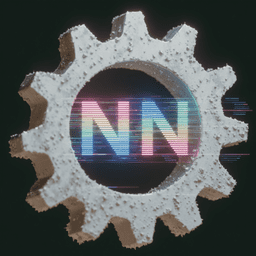